In [1]:
# Importing a bunch of tools/libs
import torch
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

torch.__version__, np.__version__, pd.__version__

('2.6.0', '2.2.2', '2.2.3')

# Data

Using the tiny-imagenet dataset, found here: http://cs231n.stanford.edu/tiny-imagenet-200.zip

Contents:
- 200 classes
- 500 samples per **train** class
- 50 samples per **validation** class
- Total file size: 239.7 MB

Not using the full ImageNet dataset for compute-time and dataset-size.

## Load data

In [2]:
### Setup data-dir
current_dir = Path(os.getcwd())
data_dir = current_dir.parent.parent / "datasets" / "ImageNet" / "data"  # I save all the datasets in this dir.
train_dir = data_dir / "train"
val_dir = data_dir / "val"

data_dir_content = os.listdir(data_dir)
print(f"[INFO] Data-dir content: {data_dir_content}")

[INFO] Data-dir content: ['.DS_Store', 'test', 'wnids.txt', 'train', 'words.txt', 'val']


In [3]:
### Training data
# Load class labels
with open(data_dir/"wnids.txt", "r") as f:
    class_labels = {line.strip(): idx for idx, line in enumerate(f)}
print(f"[INFO] Loaded class_labels: {len(class_labels)}")

# Load data
train_data = []
for class_id, label in class_labels.items():
    class_path = train_dir / class_id / "images"
    for img in os.listdir(class_path):
        train_data.append((class_path/img, label))
print(f"[INFO] Loaded train_data: {len(train_data)}")

[INFO] Loaded class_labels: 200
[INFO] Loaded train_data: 100000


In [4]:
### val data
# Load annotations
def filter_annotation(annotations):
    # Used p much for the val data only
    return {
        line.split("\t")[0]: line.split("\t")[1]
        for line in annotations
    }
with open(val_dir / "val_annotations.txt", "r") as f:
    val_mapping = filter_annotation(f)
print(f"[INFO] Loaded val annotations: {len(val_mapping)}")

# Load data
val_data = []
for img in os.listdir(val_dir/"images"):
    val_data.append((val_dir/img, class_labels[val_mapping[img]]))
print(f"[INFO] Loaded val data: {len(val_data)}")

[INFO] Loaded val annotations: 10000
[INFO] Loaded val data: 10000


In [5]:
# Store into a df
train_df = pd.DataFrame(train_data, columns=["image_path", "label"])
val_df = pd.DataFrame(val_data, columns=["image_path", "label"])
# train_df.head()
# val_df.head()


## Understand the data

Most of the important filtering has been done.\
We just need to know some basic metrics of the dataset, things like: class-distribution, etc

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_path  100000 non-null  object
 1   label       100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [7]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10000 non-null  object
 1   label       10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [8]:
# Check for repetition and "extra classes"
train_df.nunique()

image_path    100000
label            200
dtype: int64

In [12]:
# Check class-distribution
train_df["label"].value_counts().sort_index().describe()

count    200.0
mean     500.0
std        0.0
min      500.0
25%      500.0
50%      500.0
75%      500.0
max      500.0
Name: count, dtype: float64

No issues here

In [25]:
# Define the class_names (mapping: idx -> class)
class_names = list(class_labels.values())
class_names[:5]

[0, 1, 2, 3, 4]

Assuming some class-name would exist.\
Here the "class name" is a number.

Image label: 176
Image dims: (64, 64)


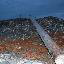

In [28]:
import PIL
import random

# Get random image
random_image_idx = random.choice(range(len(train_df["image_path"])))
random_image_path = train_df["image_path"].iloc[random_image_idx]
image = PIL.Image.open(random_image_path)
label = train_df["label"].iloc[random_image_idx]

# Get some info about the image
print(f"Image label: {label}")
print(f"Image dims: ({image.height}, {image.width})")

image

In [32]:
# View the image as an array
image_array = np.asarray(image)
print(f"Image shape: {image_array.shape}")
print(image_array)

Image shape: (64, 64, 3)
[[[ 56  98 148]
  [ 58 100 150]
  [ 62 104 154]
  ...
  [ 53  90 134]
  [ 51  88 132]
  [ 50  87 131]]

 [[ 59 101 151]
  [ 60 102 152]
  [ 62 104 154]
  ...
  [ 52  89 133]
  [ 50  87 131]
  [ 49  86 130]]

 [[ 60 102 152]
  [ 60 102 152]
  [ 61 103 153]
  ...
  [ 49  86 130]
  [ 47  84 128]
  [ 46  83 127]]

 ...

 [[210 224 224]
  [223 237 237]
  [157 171 172]
  ...
  [243 243 243]
  [227 227 227]
  [223 223 225]]

 [[115 135 136]
  [180 198 200]
  [160 178 180]
  ...
  [248 248 248]
  [255 255 255]
  [235 235 237]]

 [[150 171 174]
  [136 157 160]
  [147 166 172]
  ...
  [205 205 205]
  [252 252 254]
  [217 217 219]]]


## Preprocessing

Things like dataloaders, transforms (for augmentation), etc.\
Will try to make this as close to the paper as possible (I may add things that I prefer too).

In [ ]:
from torch.utils.data import DataLoader  # to create torch DataLoaders
from torchvision import transforms, datasets  # to create custom datasets and transforms

data_transform = transforms